# Import Modules

In [1]:
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from loguru import logger
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, PreTrainedTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import wandb

tqdm.pandas()


/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Prepare Dataset

In [3]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/openj9_processed.csv"

df = pd.read_csv(dataset_path)
df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df[df["owner"].notna()]

def clean_issue_description(text):
    cleaned_text = text.strip()
    cleaned_text = re.sub(r'0x[\da-fA-F]+', '<HEX>', cleaned_text)
    cleaned_text = re.sub(r'\b[0-9a-fA-F]{16}\b', '<HEX>', cleaned_text)
    cleaned_text = re.sub(r'\b\d{2}:\d{2}:\d{2}\.\d{3}\b', '<TIMESTAMP>', cleaned_text)
    cleaned_text = re.sub(r'\s*[-+]?\d*\.\d+([eE][-+]?\d+)?', '<FLOAT_VALUE>', cleaned_text)
    cleaned_text = re.sub(r'=\s*-?\d+', '= <PARAM_VALUE>', cleaned_text)
    
    return cleaned_text

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True)
    df["text"] = df['text'].str.replace(" +", " ", regex=True)
    df["text"] = df["text"].apply(clean_issue_description)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.progress_apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            + "\nComponent: "
            + str(x["component"])
            + "\nIssue Topic: "
            + str(x["topic_label"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

df = prepare_dataframe(df)
df = clean_data(df)
df = df.sort_values(by="issue_number")
df = df[df.component == "comp:jclextensions"]

num_issues = len(df)

print(f"Total number of issues: {num_issues}")

100%|██████████| 4381/4381 [00:00<00:00, 78434.18it/s]


Total number of issues: 31


In [4]:
df.head()

,Unnamed: 0,issue_number,issue_title,description,issue_url,issue_state,creator,labels,owner,component,text,topic_id,topic_probs,topic_label
3479,3479,9642,OpenJDK11-Acceptance TestZoneInfo310 available...,https://ci.eclipse.org/openj9/job/Pipeline-Ope...,https://github.com/eclipse-openj9/openj9/issue...,closed,pshipton,"test failure, comp:jclextensions",pshipton,comp:jclextensions,Title: OpenJDK11-Acceptance TestZoneInfo310 av...,1,"[0.010683156549930573, 0.06158875301480293, 0....",Java testing issues
3531,3531,9774,Windows 32 bit version is not built Large addr...,Duplicated from https://github.com/AdoptOpenJD...,https://github.com/eclipse-openj9/openj9/issue...,closed,pshipton,"userRaised, comp:jclextensions",pshipton,comp:jclextensions,Title: Windows 32 bit version is not built Lar...,12,"[0.040375322103500366, 0.03504777327179909, 0....",Offline systems
4302,4302,11624,Enable NX accelerated zlib on AIX machines,This issue to keep track of the PRs that enabl...,https://github.com/eclipse-openj9/openj9/issue...,closed,rmnattas,comp:jclextensions,rmnattas,comp:jclextensions,Title: Enable NX accelerated zlib on AIX machi...,7,"[0.07393849641084671, 0.03163274750113487, 0.1...",Java development kit (JDK) issues on AIX
4441,4441,11922,OJDK MH: MethodHandles.collectArguments Issues,### Errors\r\n\r\n`MethodHandles.collectArgume...,https://github.com/eclipse-openj9/openj9/issue...,closed,babsingh,"prio:low, comp:jclextensions, project:MH",babsingh,comp:jclextensions,Title: OJDK MH: MethodHandles.collectArguments...,13,"[0.0, 0.05610651150345802, 0.05578923225402832...",Java Heap Space and Null Pointer Exceptions
4921,4921,12930,JDKnext openj9-staging is failing to build on ...,https://openj9-jenkins.osuosl.org/job/Pipeline...,https://github.com/eclipse-openj9/openj9/issue...,closed,pshipton,"jdk-head, comp:jclextensions",JasonFengJ9,comp:jclextensions,Title: JDKnext openj9-staging is failing to bu...,6,"[0.02967166155576706, 0.06333968043327332, 0.0...",Build issues with OpenJ9


In [5]:
df["topic_hot"] = pd.get_dummies(df["topic_label"]).values.tolist()


In [6]:
vm_users = ['pshipton', 'keithc-ca', 'gacholio', 'tajila', 'babsingh', 'JasonFengJ9', 'fengxue-IS', 'hangshao0', 'theresa.t.mammarella', 'ChengJin01', 'singh264', 'thallium', 'ThanHenderson']
jvmti_users = ['gacholio', 'tajila', 'babsingh', 'fengxue-IS']
jclextensions_users = ['JasonFengJ9', 'pshipton', 'keithc-ca']
test_users = ['LongyuZhang', 'annaibm', 'sophiaxu0424', 'KapilPowar', 'llxia']
build_users = ['adambrousseau', 'mahdipub']
gc_users = ['dmitripivkine', 'amicic', 'kangyining', 'LinHu2016']

# Putting them in dictionaries
components = {
    'comp:vm': vm_users,
    'comp:jvmti': jvmti_users,
    'comp:jclextensions': jclextensions_users,
    'comp:test': test_users,
    'comp:build': build_users,
    'comp:gc': gc_users
}

expected_users = [user for user_list in components.values() for user in user_list]

In [7]:
df = df[df["owner"].isin(vm_users)]
print("Total issues after developer filtering:", len(df))

Total issues after developer filtering: 24


In [8]:
df.owner.value_counts()

owner
pshipton         12
keithc-ca         5
babsingh          4
JasonFengJ9       2
ThanHenderson     1
Name: count, dtype: int64

In [20]:
# Cross-Validation Fold Definition

num_cv = 10
sample_threshold = 0 # Threshold to filter developers
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 7
sliced_df = df[: samples_per_block * (block+1)]

Samples per block: 3


In [21]:
# Train and Validation preparation

X_df = sliced_df[:samples_per_block*block]
y_df = sliced_df[samples_per_block*block : samples_per_block * (block+1)]

developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]

train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

unwanted = list(test_owners - train_owners)

y_df = y_df[~y_df["owner"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")
print(f"Number of developers: {len(X_df.owner.unique())}")

Training data: 21, Validation data: 3
Number of developers: 5


<Axes: xlabel='owner'>

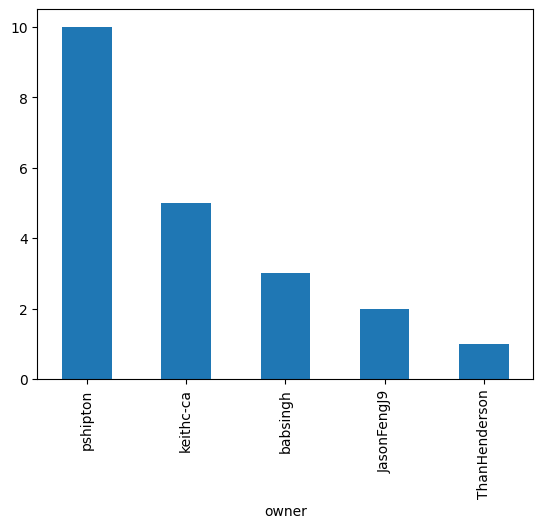

In [22]:
X_df.owner.value_counts().plot(kind="bar")

In [23]:
# Label encode developers

lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

<Axes: xlabel='owner_id'>

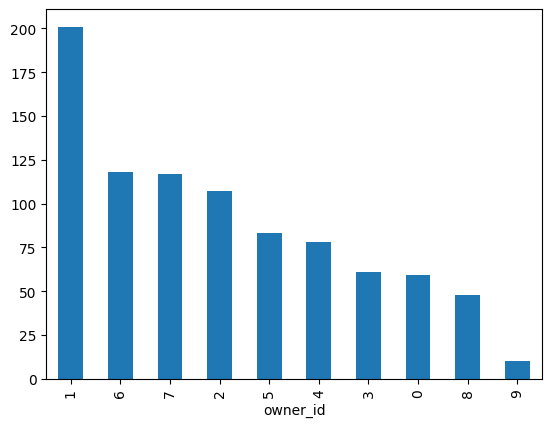

In [55]:
# Contribution plot

X_df.owner_id.value_counts().plot(kind="bar")

# Prepare PyTorch Dataset

In [21]:
class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        # self.embedding_model = SentenceTransformer("BAAI/bge-small-en")
        logger.debug("Tokenizing texts...")
        self.texts = [
            (row.text, self.tokenizer(
                row.text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ), torch.tensor([float(x.strip()) for x in row.topic_probs[1:-1].split(",")]))
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


# Modified Transformer Model

In [22]:
from transformers import DebertaModel, DebertaConfig

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [23]:
class LBTPClassifierTopic(nn.Module):
    def __init__(
        self, output_size, topic_size, unfrozen_layers=4, dropout=0.1
    ) -> None:
        super().__init__()
        model_name = "microsoft/deberta-base"
        self.base_model = AutoModel.from_pretrained(
            model_name, output_hidden_states=True
        )
        self._tokenizer = AutoTokenizer.from_pretrained(model_name)

        # Freeze embedding layers
        for p in self.base_model.embeddings.parameters():
            p.requires_grad = False

        # Freeze encoder layers till last {unfrozen_layers} layers
        for i in range(0, self.base_model.config.num_hidden_layers - unfrozen_layers):
            for p in self.base_model.encoder.layer[i].parameters():
                p.requires_grad = False

        filter_sizes = [3, 4, 5, 6]
        self._num_filters = 256
        self._max_tokens = 512
        self._embed_size = self.base_model.config.hidden_size
        self.unfrozen_layers = unfrozen_layers
        self.conv_blocks = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.Sequential(
                            nn.Conv2d(1, self._num_filters, (K, self._embed_size)),
                            nn.BatchNorm2d(self._num_filters),
                            nn.ReLU(),
                            nn.Flatten(),
                            nn.MaxPool1d(self._max_tokens - (K - 1)),
                            nn.Flatten(start_dim=1),
                        )
                        for K in filter_sizes
                    ]
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.classifiers = nn.ModuleList(
            [
                # nn.Linear(
                #     len(filter_sizes) * self._num_filters + topic_size, output_size
                # )
                nn.Linear(
                    len(filter_sizes) * self._num_filters, output_size
                )
                for _ in range(unfrozen_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask, tok_type, topic_id):
        outputs = []

        base_out = self.base_model(input_ids=input_ids, token_type_ids=tok_type, attention_mask=attention_mask)
        # pooler_out = base_out.last_hidden_state.squeeze(0)
        hidden_states = base_out.hidden_states[-self.unfrozen_layers :]

        for i in range(self.unfrozen_layers):
            batch_size, sequence_length, hidden_size = hidden_states[i].size()
            x = [
                conv(hidden_states[i].view(batch_size, 1, sequence_length, hidden_size))
                for conv in self.conv_blocks[i]
            ]
            # Concatanating outputs of the conv block of different filter sizes
            x = torch.cat(x, dim=1)
            x = self.dropout(x)
            # x = torch.cat([x, topic_id], dim=1)
            x = self.classifiers[i](x)

            outputs.append(x)

        return outputs

    def tokenizer(self) -> AutoTokenizer:
        return self._tokenizer


# Loss Functions

In [24]:
class CombineLoss(nn.Module):
    def __init__(self, weights = None) -> None:
        super().__init__()
        self._ce = nn.CrossEntropyLoss(weight=weights)
    def forward(
        self,
        prediction,
        labels
    ) -> torch.Tensor:
        loss = 0

        for i in range(len(prediction)):
            loss += self._ce(prediction[i], labels)

        return loss

# Training Parameters

In [25]:
num_classes = len(X_df["owner_id"].unique())
print(num_classes)

10


In [26]:
# wandb.login()
# wandb.init(
#     # Set the project where this run will be logged
#     project="openj9_developers", 
#     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#     name=f"developer_prediction_topicprobs_bilstm-cnn_{num_classes}_classes", 
#     # Track hyperparameters and run metadata
#     config={
#     "learning_rate": learning_rate,
#     "architecture": "Deberta-LBT-P",
#     "dataset": "openj9",
#     "epochs": epochs,
# })

In [27]:
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() # corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
weights_save_location = f"openj9_dev_compvm.pt"

# Define hyperparameters
learning_rate = 1e-4
epochs = 20
batch_size = 15

model = LBTPClassifierTopic(len(X_df.owner_id.unique()), 20, dropout=0.3)
criterion = CombineLoss(weights=None)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.1, threshold=1e-8)

In [28]:
# Prepare torch dataset from train and validation splits
train = TriageDataset(X_df, model.tokenizer())
val = TriageDataset(y_df, model.tokenizer())

2024-04-27 14:48:49.196 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-04-27 14:48:49.198 | DEBUG    | __main__:__init__:13 - Tokenizing texts...
2024-04-27 14:48:51.119 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-04-27 14:48:51.122 | DEBUG    | __main__:__init__:13 - Tokenizing texts...


In [29]:
train_dataloader = DataLoader(
    dataset=train,
    batch_size=10,
    shuffle=False if sampler else True,
    sampler=sampler,
)
val_dataloader = DataLoader(val, batch_size=10)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_loss = float("inf")

if torch.cuda.is_available():
    logger.debug(f"Selected compute device: {device}")
    model = model.cuda()
    criterion = criterion.cuda()

2024-04-27 14:48:55.542 | DEBUG    | __main__:<module>:5 - Selected compute device: cuda


In [34]:
def log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
        topk,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Top K: {topk} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"
        
        # wandb.log({
        #     "train_acc": total_acc_train / len(train_data), 
        #     "train_loss": total_loss_train / len(train_data),
        #     "val_acc": total_acc_val / len(validation_data),
        #     "val_loss": total_loss_val / len(validation_data),
        #     "top3_acc": topk,
        #     "precision": precision,
        #     "recall": recall,
        #     "f1-score": f1_score
        # })

        logger.info(log)

# Training Loop

In [35]:
model = model.cuda()

In [36]:
for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader, desc="Training Steps"):
        # print(train_input)
        train_label = train_label.to(device)
        mask = train_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = train_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = train_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = train_input[2].to(device)
        # print(tok_type.shape, input_id.shape, mask.shape)
        # print(repr.dtype, input_id.dtype, mask.dtype)

        output = model(input_id, mask, tok_type, repr)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        output = torch.sum(torch.stack(output), 0)
        acc = (output.argmax(dim=1) == train_label).sum().item()
        
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_acc_val = 0
    total_loss_val = 0
    correct_top_k = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for val_input, val_label in tqdm(val_dataloader, desc="Validation Steps"):
            val_label = val_label.to(device)
            mask = val_input[1]["attention_mask"].squeeze(1).to(device)
            input_id = val_input[1]["input_ids"].squeeze(1).to(device)
            tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
            repr = val_input[2].to(device)

            output = model(input_id, mask, tok_type, repr)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()

            output = torch.sum(torch.stack(output), 0)
            _, top_k_predictions = output.topk(3, 1, True, True)

            top_k_predictions = top_k_predictions.t()

            correct_top_k += (
                top_k_predictions.eq(
                    val_label.view(1, -1).expand_as(top_k_predictions)
                )
                .sum()
                .item()
            )

            acc = (output.argmax(dim=1) == val_label).sum().item()

            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(val_label.cpu().numpy())

            total_acc_val += acc

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )

    topk = correct_top_k / len(y_df)

    log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        X_df,
        y_df,
        topk,
    )

    val_loss = total_loss_val / len(y_df)

    if scheduler:
        scheduler.step(val_loss)

    if val_loss < best_loss:
        logger.success("Found new best model. Saving weights...")
        torch.save(model.state_dict(), weights_save_location)
        best_loss = val_loss

Validation Steps: 100%|██████████| 9/9 [00:01<00:00,  7.45it/s]
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-04-27 14:50:15.164 | INFO     | __main__:log_step:34 - Epochs: 1 | Train Loss:  0.491                     | Train Accuracy:  0.728                     | Val Loss:  1.123                     | Val Accuracy:  0.271                     | Top K: 0.49411764705882355                     | Precision:  0.209                     | Recall:  0.233                     | F1-score:  0.199
2024-04-27 14:50:15.165 | SUCCESS  | __main__:<module>:99 - Found new best model. Saving weights...
Validation Steps: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s]
2024-04-27 14:50:48.368 | INFO     | __mai

KeyboardInterrupt: 

In [13]:
sent_model = SentenceTransformer('all-MiniLM-L12-v2')

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [14]:
def concat_embs(data_df):
    X_embeddings = []

    for text, prob in zip(data_df.text.to_list(), data_df.topic_probs.to_list()):
        text = sent_model.encode(text, convert_to_tensor=True).cpu().numpy()
        prob = np.fromstring(data_df.head().iloc[0].topic_probs[1:-1], sep=",")

        embed = np.concatenate((text, prob))
        X_embeddings.append(embed)

    return X_embeddings

In [24]:
X_embeddings = sent_model.encode(X_df.text.to_list(), convert_to_tensor=True).cpu().numpy()

In [25]:
y_embeddings = sent_model.encode(y_df.text.to_list(), convert_to_tensor=True).cpu().numpy()

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score, classification_report

In [27]:
def get_top3_score(classifier):
    # Make predictions probabilities
    probabilities = classifier.predict_proba(y_embeddings)

    # Get the top 3 predictions for each sample
    top_3_indices = (-probabilities).argsort(axis=1)[:, :3]
    top_3_predictions = classifier.classes_[top_3_indices]

    # Print or use the top 3 predictions as needed
    # print("Top 3 Predictions:")
    # for i, preds in enumerate(top_3_predictions):
    #     print(f"Sample {i + 1}: {preds}")

    top_3_indices = (-probabilities).argsort(axis=1)[:, :3]
    top_3_predictions = classifier.classes_[top_3_indices]

    # Convert true labels to a list of lists
    true_labels = [[label] for label in y_df.owner_id.to_list()]

    # Convert top 3 predictions to a list of lists
    pred_labels = top_3_predictions.tolist()

    acc = 0
    for pred, true in zip(top_3_predictions, true_labels):
        if true in pred:
            acc += 1

    return acc/len(y_df)

In [28]:
accuracy = accuracy_score(y_df.owner_id.to_list(), y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_df.owner_id.to_list(), y_pred))

NameError: name 'y_pred' is not defined

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE


# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'Random Forest': RandomForestClassifier(),
    # 'SVM': SVC(),
    # 'k-NN': KNeighborsClassifier()
}

smote = SMOTE(random_state=42, k_neighbors=1)

X_train = X_embeddings
y_train = X_df.owner_id.to_list()

# X_train, y_train = smote.fit_resample(X_train, y_train)

X_test = y_embeddings
y_test = y_df.owner_id.to_list()

# Train and evaluate each model
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    
    # Additional evaluation
    print(classification_report(y_test, y_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{name} Cross-Validation Mean Accuracy: {cv_scores.mean()} +/- {cv_scores.std()}")
    print(f"Top 3 score: {get_top3_score(model)}")

# Perform hyperparameter tuning and further evaluation as needed


Logistic Regression Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           4       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Logistic Regression Cross-Validation Mean Accuracy: 0.48 +/- 0.039999999999999994
Top 3 score: 1.0


/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [34]:
smote = SMOTE(random_state=42, k_neighbors=2)

X_train = X_embeddings
y_train = X_df.owner_id.to_list()

# X_train, y_train = smote.fit_resample(X_train, y_train)

X_test = y_embeddings
y_test = y_df.owner_id.to_list()

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report

# Assuming X_train, X_test, y_train, y_test are your training and testing data
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'SVM': SVC(),
    'k-NN': KNeighborsClassifier()
}

# Dictionary to store model F1-scores
model_f1_scores = {}

# Train and evaluate each model
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="macro")
    model_f1_scores[name] = f1
    
    print(f"{name} F1-score: {f1}")

# Find the best model
best_model = max(model_f1_scores, key=model_f1_scores.get)
best_f1_score = model_f1_scores[best_model]

print(f"Best Model: {best_model}")
print(f"Best F1-score: {best_f1_score}")


Logistic Regression F1-score: 0.4
Decision Tree F1-score: 1.0
Random Forest F1-score: 0.4
k-NN F1-score: 0.6666666666666666
Best Model: Decision Tree
Best F1-score: 1.0


# Evaluation

In [ ]:
# Load best checkpoint
model.load_state_dict(torch.load(weights_save_location))

<All keys matched successfully>

In [ ]:
loader = DataLoader(val, 30)

In [ ]:
# Load embeddings for all train data
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
all_embeddings = similarity_model.encode(X_df.issue_title.to_list(), batch_size=15)

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
def get_top_k_similar_devs(issues, k=5, threshold=0.7):
    test_embed = similarity_model.encode(issues)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk_values, topk_indices = torch.topk(cos, k=k)
    
    similarities = []
    
    for idx, sim_score in zip(topk_indices, topk_values):
        sim_threshold = sim_score >= threshold
        filtered_idx = idx[sim_threshold].numpy()
        similarities.append(X_df.iloc[filtered_idx]["owner_id"].unique().tolist())

    return similarities

In [ ]:
total_acc_val = 0
total_loss_val = 0
correct_top_k = 0
correct_top_k_wo_sim = 0

all_preds = []
all_labels = []
device="cuda"

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = val_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)
        repr = val_input[2].to(device)

        output = model(input_id, mask, tok_type, repr)



        output = torch.sum(torch.stack(output), 0)

        #wo similarity
        _, top_k_wo_sim = output.topk(10, 1, True, True)

        top_k_wo_sim = top_k_wo_sim.t()

        correct_top_k_wo_sim += (
            top_k_wo_sim.eq(
                val_label.view(1, -1).expand_as(top_k_wo_sim)
            )
            .sum()
            .item()
        )


        # with similarity
        _, top_k_predictions = output.topk(10, 1, True, True)
        similar_preds = get_top_k_similar_devs(val_input[0], threshold=0.65)

        unique_preds = []

        for top, sim in zip(top_k_predictions, similar_preds):
            # print(top, sim)
            
            copy_pred = top.cpu().numpy().tolist()
            top_preds = top.cpu().numpy().tolist()[:5]

            for s in sim:
                if s not in top_preds:
                    top_preds.append(s)
            
            if len(top_preds) < 10:
                top_preds = top_preds + copy_pred[5:5 + 10 - len(top_preds)]
            
            unique_preds.append(top_preds)

        unique_preds = torch.tensor(unique_preds).cuda()
        top_k_predictions = unique_preds.t()

        correct_top_k += (
            top_k_predictions.eq(
                val_label.view(1, -1).expand_as(top_k_predictions)
            )
            .sum()
            .item()
        )

        # break

        acc = (output.argmax(dim=1) == val_label).sum().item()

        all_preds.append(output.argmax(dim=1).cpu().numpy())
        all_labels.append(val_label.cpu().numpy())

        total_acc_val += acc

In [ ]:
print(f"Correct Prediction without Similarity: {correct_top_k_wo_sim}, {correct_top_k_wo_sim / len(y_df)}")
print(f"Correct Prediction with Similarity: {correct_top_k}, {correct_top_k / len(y_df)}")

Correct Prediction without Similarity: 174, 0.925531914893617
Correct Prediction with Similarity: 173, 0.9202127659574468


In [ ]:
all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)

# Result Analysis

In [ ]:
print(classification_report(all_labels_np, all_preds_np, target_names=labels))

ValueError: Number of classes, 15, does not match size of target_names, 1843. Try specifying the labels parameter

In [ ]:
idx2label = {
    row["owner_id"]: row["owner"]
    for _, row in y_df.iterrows()
}

labels = y_df.owner_id.to_list()
labels = sorted(set(labels))
labels = [f"{idx}: {idx2label[idx]}" for idx in labels]

In [ ]:
def get_topic_distribution(owner):
    print("Training topic distribution")
    print("=======================================")
    print(X_df[X_df.owner == owner].topic_label.value_counts())

    print("\n\nTesting topic distribution")
    print("=======================================")
    print(y_df[y_df.owner == owner].topic_label.value_counts())

In [ ]:
X_df.topic_label.value_counts()

Chrome Tab and Window Behavior Issues     947
Build failures                            840
Chrome stability issues                   487
Layout Testing Issues                     400
Chrome crash reports                      391
Security and SSL issues                   372
Input and keyboard issues                 370
Webpage rendering regression issues       357
Chrome sync issues                        354
Shill WiFi configuration                  337
iOS File Issues                           321
Data Enhancement                          298
Touch and Scroll Issues                   273
DevTools Crashes                          260
GPU rendering issues                      235
Memory Leaks in WebCore and Blink         220
Performance testing issues in Chromium    197
WebRTC audio/video issues                 184
Bookmark issues                           174
Performance Regression in Blink            13
Name: topic_label, dtype: int64

In [ ]:
get_topic_distribution("a...@chromium.org")

Training topic distribution
Chrome Tab and Window Behavior Issues     10
Webpage rendering regression issues        5
Memory Leaks in WebCore and Blink          4
Chrome stability issues                    4
DevTools Crashes                           3
Data Enhancement                           3
Input and keyboard issues                  3
Touch and Scroll Issues                    2
Bookmark issues                            1
Security and SSL issues                    1
Chrome sync issues                         1
Layout Testing Issues                      1
Build failures                             1
iOS File Issues                            1
Performance testing issues in Chromium     1
Name: topic_label, dtype: int64


Testing topic distribution
Chrome Tab and Window Behavior Issues     17
Webpage rendering regression issues        7
DevTools Crashes                           6
iOS File Issues                            6
Touch and Scroll Issues                    4
Input and k